# GreenValueNet

This notebook contains the code needed to execute the GreenValueNet hedonic pricing neural network. 

### Set up and data loading

In [1]:
import joblib
import keras
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from data_load_funcs import get_params, load_data_catalogue
from processing_funcs import process_data, normalise_values
from model_funcs import *

cwd = Path.cwd()
params = get_params()
data_catalogue = load_data_catalogue()

The `dataset.csv` file from `data/interim_files` is loaded if it already exists, or constructed if not. To build the dataset please follow the steps in [Annex 1 of the ReadMe file](readme.md#annex-1) to esnure all relevant files have been downloaded. 

In [2]:
dataset = process_data(data_catalogue, params)

# show summary stats
summary_stats = dataset.describe().transpose()[['mean', 'std', 'max', 'min']]
summary_stats.columns = ['Mean', 'Std Dev', 'Maximum', 'Minimum']
print(summary_stats)

Processed dataset already exists.
Loading exisitng dataset...
                                  Mean    Std Dev       Maximum   Minimum
ln_price                     12.393713   0.658136     18.134158  0.116855
propertytype                  1.328094   1.085676      3.000000  0.000000
oldnew                        0.134435   0.341119      1.000000  0.000000
duration                      0.325202   0.468482      2.000000  0.000000
current_energy_efficiency    61.056443  12.444568    347.000000  0.000000
potential_energy_efficiency   0.805024   0.140106      1.000000  0.000000
total_floor_area             91.622326  68.669650  60506.700000  0.000000
extension_count               0.495053   0.743755      4.000000  0.000000
number_habitable_rooms        4.521529   1.748808    100.000000  0.000000
number_heated_rooms           4.437662   1.754007    100.000000  0.000000
construction_age_band         4.477500   3.153767     10.000000 -1.000000
coastline_dist               57.173176  38.518186 

In [3]:
print(dataset.shape)
print(dataset.isnull().sum())

(12909200, 26)
transactionid                  0
ln_price                       0
postcode                       0
propertytype                   0
oldnew                         0
duration                       0
current_energy_efficiency      0
potential_energy_efficiency    0
total_floor_area               0
extension_count                0
number_habitable_rooms         0
number_heated_rooms            0
construction_age_band          0
coastline_dist                 0
prim_school_dist               0
sec_school_dist                0
roads_dist                     0
nat_park_dist                  0
nat_trust_dist                 0
ttwa_dist                      0
dom_builds_share               0
garden_share                   0
non_dom_builds_share           0
path_share                     0
greenspace_share               0
water_share                    0
dtype: int64


Now we normalise any non-encoded variables to increase speed of learning of algorithm and convert the dataset to an array of inputs, and an associated output array.

In [4]:
norm_cols = [col for col in dataset.columns if col not in params['non_norm_cols']]
for col in norm_cols:
    dataset[col] = normalise_values(dataset[col])

# creates an input array of shape m,x and an output array of shape m
x, y, derivative_index = create_x_y_arr(dataset, params)

The dataset is then split into train, dev and test sets using sci-kit learn.

In [5]:
x_train, x_dev, x_test, y_train, y_dev, y_test = split_to_test_dev_train(
    x,
    y,
    params['dev_size'],
    params['test_size'],
    prop=False
)

## Benchmarking

To evaluate the performance of my neural network we use random forest and XGBoost regressions as baseline models. We optimise based on the mean squared error (MSE) and report this as our measure of performance.

### Random Forest


In [ ]:
# run baseline random forest regression using scikit-learn
rf_hp_space = params['tuning_dict']['rf_space']
rfr_model = baseline_model(
    x_train,
    y_train,
    RandomForestRegressor,
    tuning=False,
    tuning_params=rf_hp_space,
    tuning_iter=params['tuning_dict']['n_iter']
)

# generate predictions and measure according to mean squared error
rfr_pred, rfr_mse = generate_pred_metric(rfr_model, mean_squared_error, x_dev, y_dev)

### XGBoost

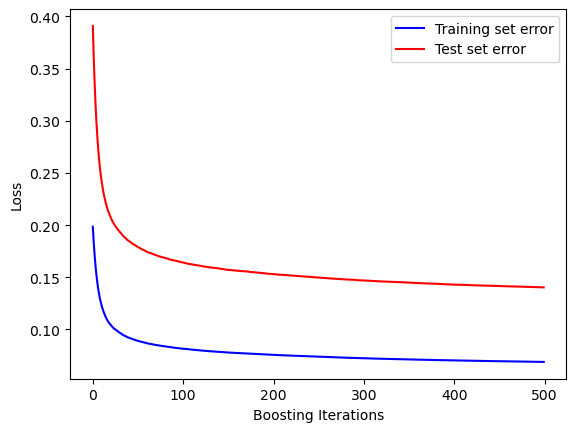

In [6]:
# run baseline gradient boosting regression using scikit-learn
xg_hp_space = params['tuning_dict']['xg_space']
xgb_model = baseline_model(
    x_train,
    y_train,
    HistGradientBoostingRegressor,
    tuning=False,
    tuning_params=xg_hp_space,
    tuning_iter=params['tuning_dict']['n_iter'],
    max_iter = 500,
    max_depth = 18,
    learning_rate = 0.1,
    min_samples_leaf=50
)

# generate predictions and measure according to mean squared error
xgb_pred, xgb_mse = generate_pred_metric(xgb_model, mean_squared_error, x_dev, y_dev)

# plot loss over iterations
plot_loss(xgb_model, validation_data=(x_dev, y_dev), metric=mean_squared_error)

## Neural networks

We know build some neural networks. Number of epochs, hidden layers, and nodes in hidden layers is initially set with rules of thumb but then optimiszed using hyperparameter tuning.

In [7]:
# set epochs based on past convergence behaviour
epochs = 25

# set n_hidden_units to be mean of input and output layer sizes
n_hidden_units = round((x_train.shape[1] + 1) / 2)

### Single Layer Neural Network

A single hidden layer with ReLU activation is used with a linear output layer.

In [8]:
tune_nn = False
single_nn = build_neural_net(
    input_shape = x_train.shape[1:],
    n_hidden_units = n_hidden_units,
    n_layers = 1,
    tuning = tune_nn,
)
single_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 301 (1.18 KB)
Trainable params: 301 (1.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
single_nn.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=32,
    validation_data = (x_dev, y_dev)
)

Epoch 1/25
402788/402788 [==============================] - 520s 1ms/step - loss: 0.4320 - mse: 0.4320 - val_loss: 0.2292 - val_mse: 0.2292
Epoch 2/25
402788/402788 [==============================] - 527s 1ms/step - loss: 0.2450 - mse: 0.2450 - val_loss: 0.2485 - val_mse: 0.2485
Epoch 3/25
402788/402788 [==============================] - 518s 1ms/step - loss: 0.2374 - mse: 0.2374 - val_loss: 0.2290 - val_mse: 0.2290
Epoch 4/25
402788/402788 [==============================] - 553s 1ms/step - loss: 0.2334 - mse: 0.2334 - val_loss: 0.2358 - val_mse: 0.2358
Epoch 5/25
402788/402788 [==============================] - 560s 1ms/step - loss: 0.2335 - mse: 0.2335 - val_loss: 0.2290 - val_mse: 0.2290
Epoch 6/25
402788/402788 [==============================] - 561s 1ms/step - loss: 0.2331 - mse: 0.2331 - val_loss: 0.2278 - val_mse: 0.2278
Epoch 7/25
402788/402788 [==============================] - 561s 1ms/step - loss: 0.2331 - mse: 0.2331 - val_loss: 0.2303 - val_mse: 0.2303
Epoch 8/25
402788/40

### Deep Neural Network

The full model is specified as a deep neural network using layers with ReLU activation functions with a linear activation in the output layer. The choice of number of layers was initially kept small due to computational processing constraints.

In [10]:
tune_nn = False

deep_nn = build_neural_net(
    input_shape = x_train.shape[1:],
    n_hidden_units = n_hidden_units,
    n_layers = 10,
    tuning = tune_nn
)

deep_nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12)                288       
                                                                 
 dense_3 (Dense)             (None, 12)                156       
                                                                 
 dense_4 (Dense)             (None, 12)                156       
                                                                 
 dense_5 (Dense)             (None, 12)                156       
                                                                 
 dense_6 (Dense)             (None, 12)                156       
                                                                 
 dense_7 (Dense)             (None, 12)                156       
                                                                 
 dense_8 (Dense)             (None, 12)               

In [11]:
deep_nn.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=32,
    validation_data = (x_dev, y_dev)
)

Epoch 1/25
402788/402788 [==============================] - 210s 520us/step - loss: 0.2016 - mse: 0.2016 - val_loss: 0.1856 - val_mse: 0.1856
Epoch 2/25
402788/402788 [==============================] - 213s 530us/step - loss: 0.1859 - mse: 0.1859 - val_loss: 0.1904 - val_mse: 0.1904
Epoch 3/25
402788/402788 [==============================] - 224s 556us/step - loss: 0.1847 - mse: 0.1847 - val_loss: 0.1797 - val_mse: 0.1797
Epoch 4/25
402788/402788 [==============================] - 208s 516us/step - loss: 0.1844 - mse: 0.1844 - val_loss: 0.1789 - val_mse: 0.1789
Epoch 5/25
402788/402788 [==============================] - 208s 517us/step - loss: 0.1842 - mse: 0.1842 - val_loss: 0.1789 - val_mse: 0.1789
Epoch 6/25
402788/402788 [==============================] - 214s 531us/step - loss: 0.1841 - mse: 0.1841 - val_loss: 0.1825 - val_mse: 0.1825
Epoch 7/25
402788/402788 [==============================] - 211s 523us/step - loss: 0.1840 - mse: 0.1840 - val_loss: 0.2044 - val_mse: 0.2044
Epoch 

### Hyperparameter tuning

We know run the deep neural network but rather than setting the learning rate, hidden units and hidden layers ourself we let the model determine the optimal set of hyperparameters using Bayesian updating of the hyperparameters.

In [12]:
tune_nn = True

deep_nn_t = build_neural_net(
    input_shape = x_train.shape[1:],
    n_hidden_units = n_hidden_units,
    n_layers = 10,
    tuning = tune_nn
)

if tune_nn:
    tuner = run_hp_search(
        x_train,
        y_train,
        validation_set=(x_dev, y_dev),
        search_name='neural_net_240902'
    )
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(best_hps.values)
    deep_nn_t = tuner.hypermodel.build(best_hps)

deep_nn_t.summary()

Trial 10 Complete [00h 07m 39s]
mse: 0.1860162615776062

Best mse So Far: 0.15837876498699188
Total elapsed time: 01h 43m 09s
{'n_units': 24, 'n_layers': 10, 'lr': 0.001}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                576       
                                                                 
 dense_7 (Dense)             (None, 24)                600       
                                                                 
 dense_8 (Dense)             (None, 24)                600       
                                                                 
 dense_9 (Dense)             (None, 24)                600       
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
 dense_11 (Dens

In [13]:
deep_nn_t.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=32,
    validation_data = (x_dev, y_dev)
)

Epoch 1/25
402788/402788 [==============================] - 211s 521us/step - loss: 0.1882 - mse: 0.1882 - val_loss: 0.1644 - val_mse: 0.1644
Epoch 2/25
402788/402788 [==============================] - 207s 515us/step - loss: 0.1578 - mse: 0.1578 - val_loss: 0.1562 - val_mse: 0.1562
Epoch 3/25
402788/402788 [==============================] - 208s 516us/step - loss: 0.1549 - mse: 0.1549 - val_loss: 0.1543 - val_mse: 0.1543
Epoch 4/25
402788/402788 [==============================] - 209s 519us/step - loss: 0.1536 - mse: 0.1536 - val_loss: 0.1544 - val_mse: 0.1544
Epoch 5/25
402788/402788 [==============================] - 209s 518us/step - loss: 0.1526 - mse: 0.1526 - val_loss: 0.1506 - val_mse: 0.1506
Epoch 6/25
402788/402788 [==============================] - 211s 523us/step - loss: 0.1520 - mse: 0.1520 - val_loss: 0.1525 - val_mse: 0.1525
Epoch 7/25
402788/402788 [==============================] - 212s 527us/step - loss: 0.1518 - mse: 0.1518 - val_loss: 0.1514 - val_mse: 0.1514
Epoch 

## Results

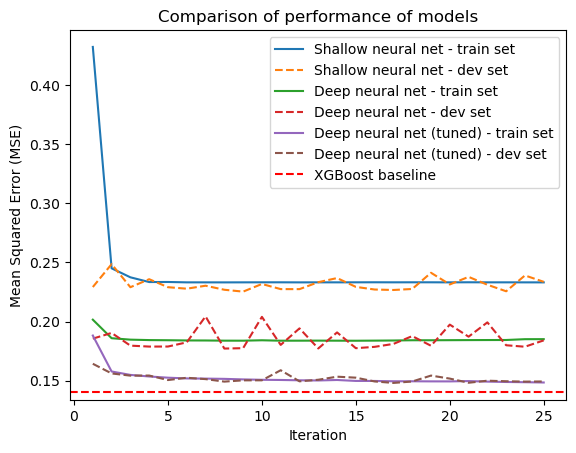

In [17]:
nn_dict = {
    'Shallow neural net': single_nn,
    'Deep neural net': deep_nn,
    'Deep neural net (tuned)': deep_nn_t
}
baseline_dict = {
    # 'Random Forest': rfr_mse,
    'XGBoost baseline': xgb_mse
}

generate_plot(nn_dict, baseline_dict, save=False, name='model_mse_2402019.png')

### Calculating marginal valuation of environmental attributes

Once we have a model with environmental attributes as features and log of house price as the target variable, we can begin to construct the marginal willingness to pay for environmental attributes, and therefore get a proxy for their value.

The partial derivative of `ln_price` w.r.t an input variable can be evaluated during the backwards propagation stage of the model fitting. By evaluating this derivative at a variety of samples, we can plot a valulation curve for the change in $ln(price)$ for a change in the input feature by 1 standard deviation.

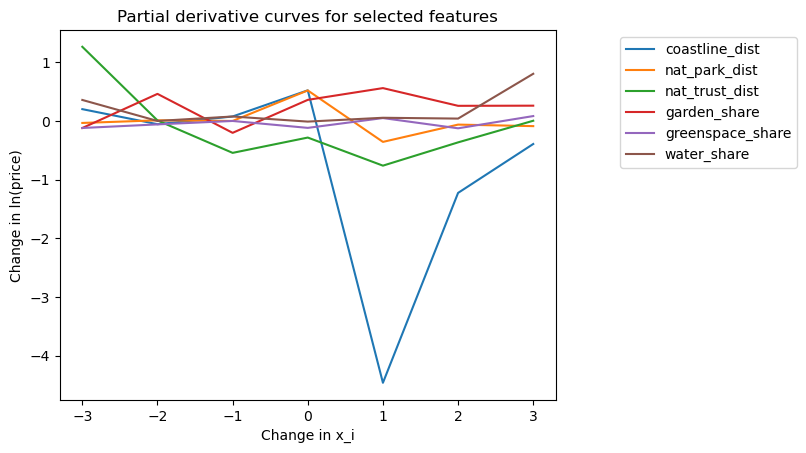

In [18]:
# extract the gradients from the model
if tune_nn:
    model_to_plot = deep_nn_t
else:
    model_to_plot = deep_nn
points = np.arange(-3, 4, 1)
gradients = calc_partial_grad(
    model_to_plot,
    x_dev,
    derivative_index,
    points)

plot_partial_grads(gradients, points, derivative_index, save=False, name='partial_grads_240216.png')

### Saving models

Here we save the pre-trained models so they can be loaded and used.

In [19]:
model_dir = cwd / "outputs" / "models"

# save models as tensor objects
if tune_nn:
    deep_nn_t.save(model_dir / "deep_nn_tuned.keras")
deep_nn.save(model_dir / "deep_nn_no_tuning.keras")
    
single_nn.save(model_dir / "shallow_nn.keras")

# save models as joblib files
joblib.dump(xgb_model, model_dir / "xgboost.joblib")

['/Users/Felix_Gallagher/Dev/GitHub_personal/GreenValueNet/outputs/models/xgboost.joblib']